In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import log_cholesky
import pyfrechet.metric_spaces.wasserstein_1d as W1d

import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper", rc={
        "axes.labelsize": 20,
        "xtick.labelsize": 20
    })

fc = 0.9

def geodesic(x, theta, mu):
        return theta * x + (1-theta)*mu

INFO: Using numpy backend


# SPD

12.350000000000001


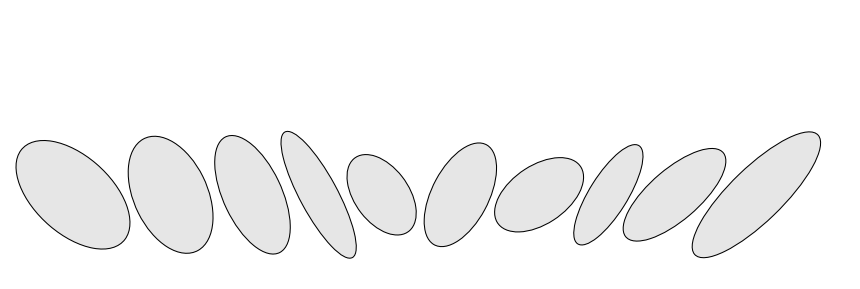

In [203]:
def log_chol_to_L(DL):
    n = DL.shape[0]
    d = int((-1 + np.sqrt(1 + 8 * n)) / 2)
    L = np.zeros(shape=(d,d))
    L[np.diag_indices(d)] = np.exp(DL[:d])
    L[np.tril_indices(d, -1)] = DL[d:]
    return L

def noise(x, s1, s2):
    C_eps = np.zeros_like(x)
    C_eps[:M.dim] = s1 * np.random.normal(size=M.dim)
    C_eps[M.dim:] = s2 * np.random.normal(size=x.shape[0] - M.dim)
    
    L_eps = log_chol_to_L(C_eps)
    x = log_cholesky.log_chol_to_spd(x)
    return log_cholesky.spd_to_log_chol(L_eps.dot(x).dot(L_eps.T))


M=log_cholesky.LogCholesky(10)
def sim(T, phi, mu, s1=0.5, s2=0.5):    
    x = np.zeros((T, mu.shape[0])) + mu
    for i in range(1,T):
        x[i, :] = geodesic(x[i-1], phi, mu)
        # # log-normal noise on eigenvalues
        # x[i, :M.dim] += s1 * np.random.normal(size=M.dim)
        # # normal noise on the lower-triangular elements
        # x[i, M.dim:] += s2 * np.random.normal(size=mu.shape[0] - M.dim)

        x[i, :] = noise(x[i,:], s1, s2)

    return x
    

mean = log_cholesky.spd_to_log_chol(np.eye(M.dim))

from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance matrix (`cov`).
    """
    if ax is None:
        ax = plt.gca()

    # Decompose and sort the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]

    # Compute the angle between the x-axis and the largest eigenvector
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellipse)

np.random.seed(3)
x = sim(20, 0.8, mean, s1=0.2, s2=0.5)

n = 10
dx = np.array([0,1.55,1.3,1.05,1,1.25,1.25,1.1,1.05,1.3])

fig, ax = plt.subplots(figsize=(np.sum(dx),3.5))
# fig, ax = plt.subplots(figsize=(20,5))

for i in range(n):
    cov_matrix = log_cholesky.log_chol_to_spd(x[i+1, :])[:2, :2] / 10
    position = [np.cumsum(dx)[i], -.75]
    plot_cov_ellipse(cov_matrix, position, ax=ax, label=i, facecolor=(fc,fc,fc), edgecolor='black', linewidth=0.75)

plt.xlim(-1,np.sum(dx)+1.5)
print(np.sum(dx)+1.5)
# plt.xlim(-1,15)
plt.ylim(-2,2)
ax=plt.gca()
plt.grid(False)
ax.yaxis.set_visible(False)  
# plt.xlabel('Time')
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.plot((1), (-1.987), ls="", marker=">", ms=10, color=(.83,.83,.83), transform=ax.get_yaxis_transform(), clip_on=False)

plt.savefig("./plots/sample_log_cholesky.pdf", bbox_inches='tight', transparent=True,)

# Wasserstein

/var/folders/zr/h_4389yx0t372wtwlt21sddw0000gn/T/ipykernel_63366/4208879184.py:8: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)


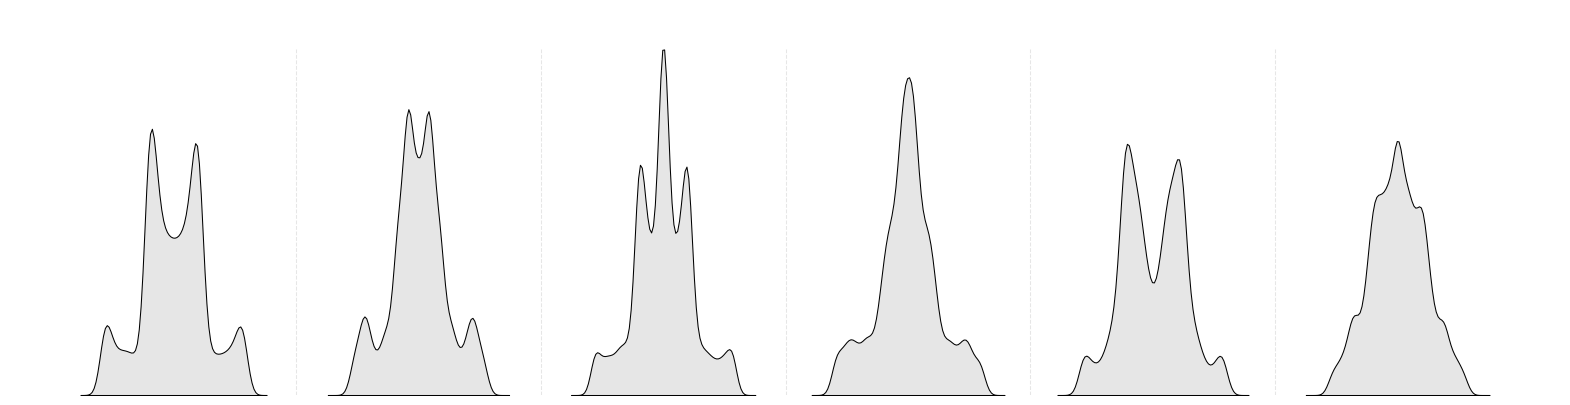

In [5]:
W = W1d.Wasserstein1D()
GRID = W1d.Wasserstein1D.GRID# np.linspace(0,1,1000)

def sim(T, phi, mu):
    x = np.zeros((T, mu.shape[0])) + mu
    for i in range(1,T):
        z = geodesic(x[i-1], phi, mu)
        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        scale = np.abs(np.max(z) - np.min(z))
        x[i, :] = scale*(z/scale - np.sin(np.pi*k*z)/np.pi/abs(k))
    return x

STD_NORMAL_Q = stats.norm.ppf(GRID)
STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs
np.random.seed(11)
x = sim(10, 0.8, STD_NORMAL_Q)
plt.figure(figsize=(20,5))
grid = np.linspace(-4,4,100)
n=10_000
for i in range(1,7):
    # k = q_to_d(x[i,:],n=10000)
    _x = np.interp(np.random.rand(n), GRID, x[i,:])
    k = stats.gaussian_kde(_x, bw_method='scott')
    # plt.plot(i*8+grid,k(grid),label=str(i))
    # plt.plot(i+grid,x[i,:],label=str(i))
    # plt.plot(GRID, x[i,:],label=str(i))
    # plt.hist(k(), bins=100)
    grid = np.linspace(np.min(_x)-1, np.max(_x)+1, 100)
    plt.fill_between(grid+i*11, k(grid), ec='black', fc=(fc,fc,fc), alpha=1, linewidth=0.75)
    if i < 6:
        plt.axvline(i*11+5.5, linestyle='--', color=(fc,fc,fc), alpha=1, linewidth=0.75, ymax=.9)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.grid(axis='x');
plt.ylim(0,0.5)
# plt.xlabel('Time')
# plt.xticks([11,22,33,44,55,66], [1,2,3,4,5,6])
# plt.xticks([], [])

ax = plt.gca()
# plt.xlabel('Time')
plt.xticks([])
ax.yaxis.set_visible(False)  
# plt.ylabel('Density')
# plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.plot((1), (0), ls="", marker=">", ms=10, color=(.83,.83,.83), transform=ax.get_yaxis_transform(), clip_on=False)
plt.savefig("./plots/sample_wasserstein.pdf", bbox_inches='tight', transparent=True,)

# R

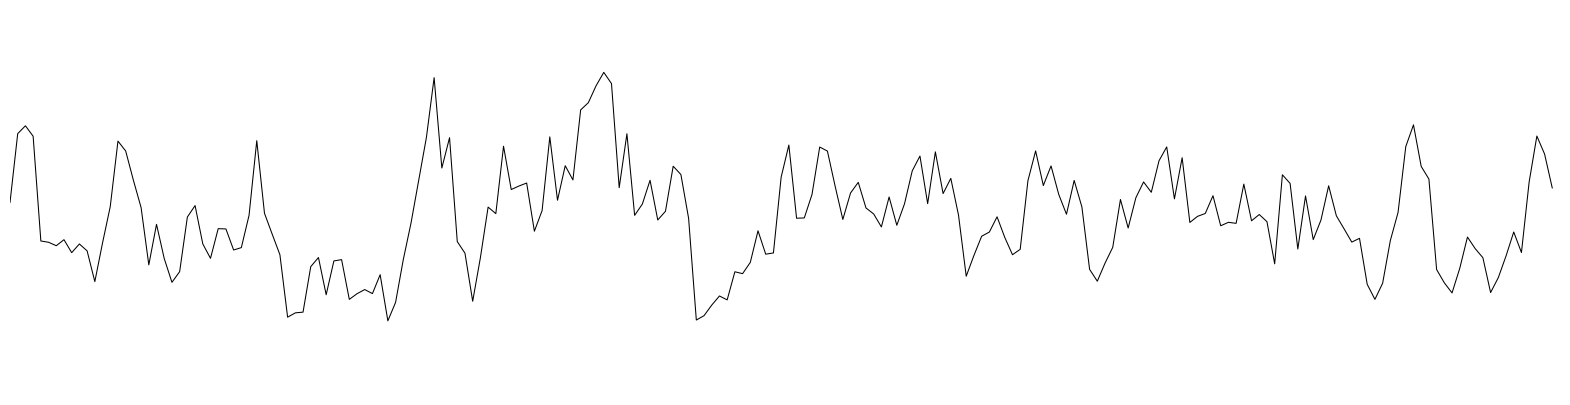

In [282]:
def sim(T, phi, mu):
    sig = 0.2
    x = np.zeros((T,1)) + mu

    for i in range(1,T):
        # z = np.exp(sig*np.random.randn())
        z = (1+sig*np.random.randn())
        x[i] = z * geodesic(x[i-1], phi, mu)
        
    return x

np.random.seed(3)
x = sim(201, 0.8, 1)
plt.figure(figsize=(20,5))
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.fill_between(np.arange(101), x.flatten(), ec='black', fc=(fc,fc,fc), alpha=1, linewidth=0.75)
plt.plot(np.arange(x.shape[0]), x.flatten(),c='black', alpha=1, linewidth=0.75) # ec='black', fc=(fc,fc,fc), alpha=1, linewidth=0.75)
# plt.plot(np.arange(x.shape[0]), np.log(np.abs(y.flatten() - x.flatten())),c='black', alpha=1, linewidth=0.75) # ec='black', fc=(fc,fc,fc), alpha=1, linewidth=0.75)
# plt.plot(np.arange(x.shape[0]), y.flatten(),c='black', alpha=1, linewidth=0.75) # ec='black', fc=(fc,fc,fc), alpha=1, linewidth=0.75)
# ax.plot((1), (0), ls="", marker=">", ms=10, color=(.83,.83,.83), transform=ax.get_yaxis_transform(), clip_on=False)
plt.xticks([])
plt.yticks([])
# plt.yticks([0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
# plt.yticks([0, 0.5, 1, 1.5, 2])
# plt.yticks([0, 1,2,3,4])
plt.ylim(0,2)
plt.xlim(0, x.shape[0])
# plt.xlabel('Time')
plt.savefig("./plots/sample_r.pdf", bbox_inches='tight', transparent=True,)